In [1]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import random
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from datetime import date
import time


## Spotify API Call

In [102]:
client_id = '83c1f666855f45f89b2216e55c7bf535'
client_secret = '9bfd86b3fd3c43ada84e1f282fb1df35'
redirect_uri='http://localhost:8910/callback'
username = '61d4pmnwnwjt7xz9tj6v3txho'

scope = 'user-top-read'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)
                                                      
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

token = util.prompt_for_user_token(username,scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    

## Top Tracks Extraction

In [3]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='short_term')

#Convert the results into a dataframe
track_name = []
track_id = []
artist = []
new = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_top_tracks = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_top_tracks

track_name  \
0                                             Maps   
1                                    Heaven's Gate   
2                                 A September Song   
3                              Love on the Weekend   
4   If the World Was Ending - feat. Julia Michaels   
5                                Perfect Strangers   
6                                  Banana Pancakes   
7                                        Trainsong   
8                                    Howling Light   
9                                  Feels Like Love   
10                                 All the Cowboys   
11                                       My Person   
12                                        Comeback   
13                    Maybe We Will - 2020 Version   
14                         Every Girl I Ever Loved   
15                                    Meet The Man   
16                  Hello Beautiful - 2020 Version   
17                                         Shallow   
18                             Thousand - Acoustic   
19                                           Creep   
20                                         windows   
21                                 OK Not To Be OK   
22                            Just the Way You Are   
23                                         TiK ToK   
24                            Love The Way You Lie   
25                                        Dynamite   
26                        Feel Again (Feat. Au/Ra)   
27                                     Free Spirit   
28                                          Misery   
29                           Be Kind (with Halsey)   
30                                        Takeaway   
31                                Hey, Soul Sister   
32                   Past Life (with Selena Gomez)   
33                                         Daisies   
34                                          Wonder   
35                                    Slow Grenade   
36                                California Gurls   
37                                   Lose Somebody   
38                                     Bad Romance   
39                      Drops of Jupiter (Tell Me)   

                                                album                track_id  \
0                                                   V  4gbVRS8gloEluzf0GzDOFc   
1                                        Desert Songs  62EuvgIqhc9o5DPqKse952   
2                                              Demons  6BNZGQBMwlF2Zmsxcq08iC   
3                                 Love on the Weekend  0j2WBxWZnWti5TpSxjJvPb   
4      If the World Was Ending (feat. Julia Michaels)  2kJwzbxV2ppxnQoYw4GLBZ   
5                                                Blue  3P3pw6C19j31Rnzgo3JG7o   
6                                   In Between Dreams  451GvHwY99NKV4zdKPRWmv   
7                                         Another Day  4pxW6L91xBeUrWygGcSHOe   
8                                 Year In The Kingdom  7E6iObqRWYyzoZdgPOgdvi   
9                                    Noah Schnacky EP  04hHPq6kXTbcSSDrdaP3s4   
10                                    All the Cowboys  13TOvHAfdO8wryqxBL7fnI   
11                                         Wilderness  1MOOJuxUu9QiQE9GgkYYPb   
12                                   Noah Schnacky EP  1wr0HUe5tFDlN32jfwt9IS   
13                                   Noah Schnacky EP  26LKaGfw6ZolgGArPDEN2R   
14                            Every Girl I Ever Loved  4fbnx3oevoht9LNrauDsVP   
15                                   Noah Schnacky EP  54iGR32Ba6mRtwLASLkohd   
16                                   Noah Schnacky EP  6PZR4jQ09UmM9hphbIblQQ   
17                                            Shallow  6ysfrXnADdeTtW20oSybln   
18                                Thousand (acoustic)  0NSqOUjf55rgVEqN7e9fhb   
19                                              Creep  0SCox9Tmm4AxcnhDXZglYB   
20                  It's Got Four Sad Songs on It BTW  0vCxilr1Z63f1XSQhu2GJN   
21                                    OK No

## Features Extraction

In [4]:
def get_features(sp,df):
    playlist = df[['track_id','track_name']]
    features = []
    
    features += sp.audio_features(playlist.iloc[0:50, 0])

    feature_list = []
    for feature in features:
        feature_list.append([feature['danceability'],
                        feature['energy'],
                        feature['key'],
                        feature['loudness'],
                        feature['mode'],
                        feature['speechiness'],
                        feature['acousticness'],
                        feature['instrumentalness'],
                        feature['liveness'],
                        feature['valence'],
                        feature['tempo'],
                        feature['duration_ms']]
                       )

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    return df_playlist_audio_features
    

In [5]:
df_final_features = get_features(sp,df_top_tracks)
#Drop the mode feature as it is binary
del df_final_features['mode']
df_final_features

track_id                                      track_name  \
0   4gbVRS8gloEluzf0GzDOFc                                            Maps   
1   62EuvgIqhc9o5DPqKse952                                   Heaven's Gate   
2   6BNZGQBMwlF2Zmsxcq08iC                                A September Song   
3   0j2WBxWZnWti5TpSxjJvPb                             Love on the Weekend   
4   2kJwzbxV2ppxnQoYw4GLBZ  If the World Was Ending - feat. Julia Michaels   
5   3P3pw6C19j31Rnzgo3JG7o                               Perfect Strangers   
6   451GvHwY99NKV4zdKPRWmv                                 Banana Pancakes   
7   4pxW6L91xBeUrWygGcSHOe                                       Trainsong   
8   7E6iObqRWYyzoZdgPOgdvi                                   Howling Light   
9   04hHPq6kXTbcSSDrdaP3s4                                 Feels Like Love   
10  13TOvHAfdO8wryqxBL7fnI                                 All the Cowboys   
11  1MOOJuxUu9QiQE9GgkYYPb                                       My Person   
12  1wr0HUe5tFDlN32jfwt9IS                                        Comeback   
13  26LKaGfw6ZolgGArPDEN2R                    Maybe We Will - 2020 Version   
14  4fbnx3oevoht9LNrauDsVP                         Every Girl I Ever Loved   
15  54iGR32Ba6mRtwLASLkohd                                    Meet The Man   
16  6PZR4jQ09UmM9hphbIblQQ                  Hello Beautiful - 2020 Version   
17  6ysfrXnADdeTtW20oSybln                                         Shallow   
18  0NSqOUjf55rgVEqN7e9fhb                             Thousand - Acoustic   
19  0SCox9Tmm4AxcnhDXZglYB                                           Creep   
20  0vCxilr1Z63f1XSQhu2GJN                                         windows   
21  0zzVTGyRrWpQu8Fr28NRAv                                 OK Not To Be OK   
22  7BqBn9nzAq8spo5e7cZ0dJ                            Just the Way You Are   
23  0HPD5WQqrq7wPWR7P7Dw1i                                         TiK ToK   
24  15JINEqzVMv3SvJTAXAKED                            Love The Way You Lie   
25  1DqdF42leyFIzqNDv9CjId                                        Dynamite   
26  1fgC2MHbJnPgvDfdTpC62c                        Feel Again (Feat. Au/Ra)   
27  2kAIpGWnlFLQh48iut6Zzq                                     Free Spirit   
28  3XojqFisTYTQm2p7HK5p4P                                          Misery   
29  3Z8FwOEN59mRMxDCtb8N0A                           Be Kind (with Halsey)   
30  3g0mEQx3NTanacLseoP0Gw                                        Takeaway   
31  4HlFJV71xXKIGcU3kRyttv                                Hey, Soul Sister   
32  4P6IttK2PRBjyr3fm0pP7t                   Past Life (with Selena Gomez)   
33  4uqh9bualXNHXXwO2wPorc                                         Daisies   
34  5KCbr5ndeby4y4ggthdiAb                                          Wonder   
35  5z8uLrYMcUVvzTV28twt44                                    Slow Grenade   
36  6tS3XVuOyu10897O3ae7bi                                California Gurls   
37  7xbWAw3LMgRMn4omR5yVn3                                   Lose Somebody   
38  0SiywuOBRcynK0uKGWdCnn                                     Bad Romance   
39  2hKdd3qO7cWr2Jo0Bcs0MA                      Drops of Jupiter (Tell Me)   

    danceability  energy  key  loudness  speechiness  acousticness  \
0          0.742  0.7130    1    -5.522       0.0303      0.020500   
1          0.667  0.3180    1   -12.666       0.0375      0.849000   
2          0.424  0.0317    3   -16.702       0.0483      0.944000   
3          0.729  0.5460    7    -9.305       0.0285      0.547000   
4          0.464  0.4730    1   -10.086       0.1290      0.866000   
5          0.730  0.8610    1    -4.100       0.0451      0.390000   
6          0.816  0.3750    7    -8.053       0.0996      0.607000   
7          0.455  0.1990    4   -10.363       0.0341      0.916000   
8          0.531  0.2010    0   -10.974       0.0300      0.799000   
9          0.639  0.8450    2    -5.139       0.0414      0.001170   
10         0.501  0.5540    9    -6.292       0.0

## EDA

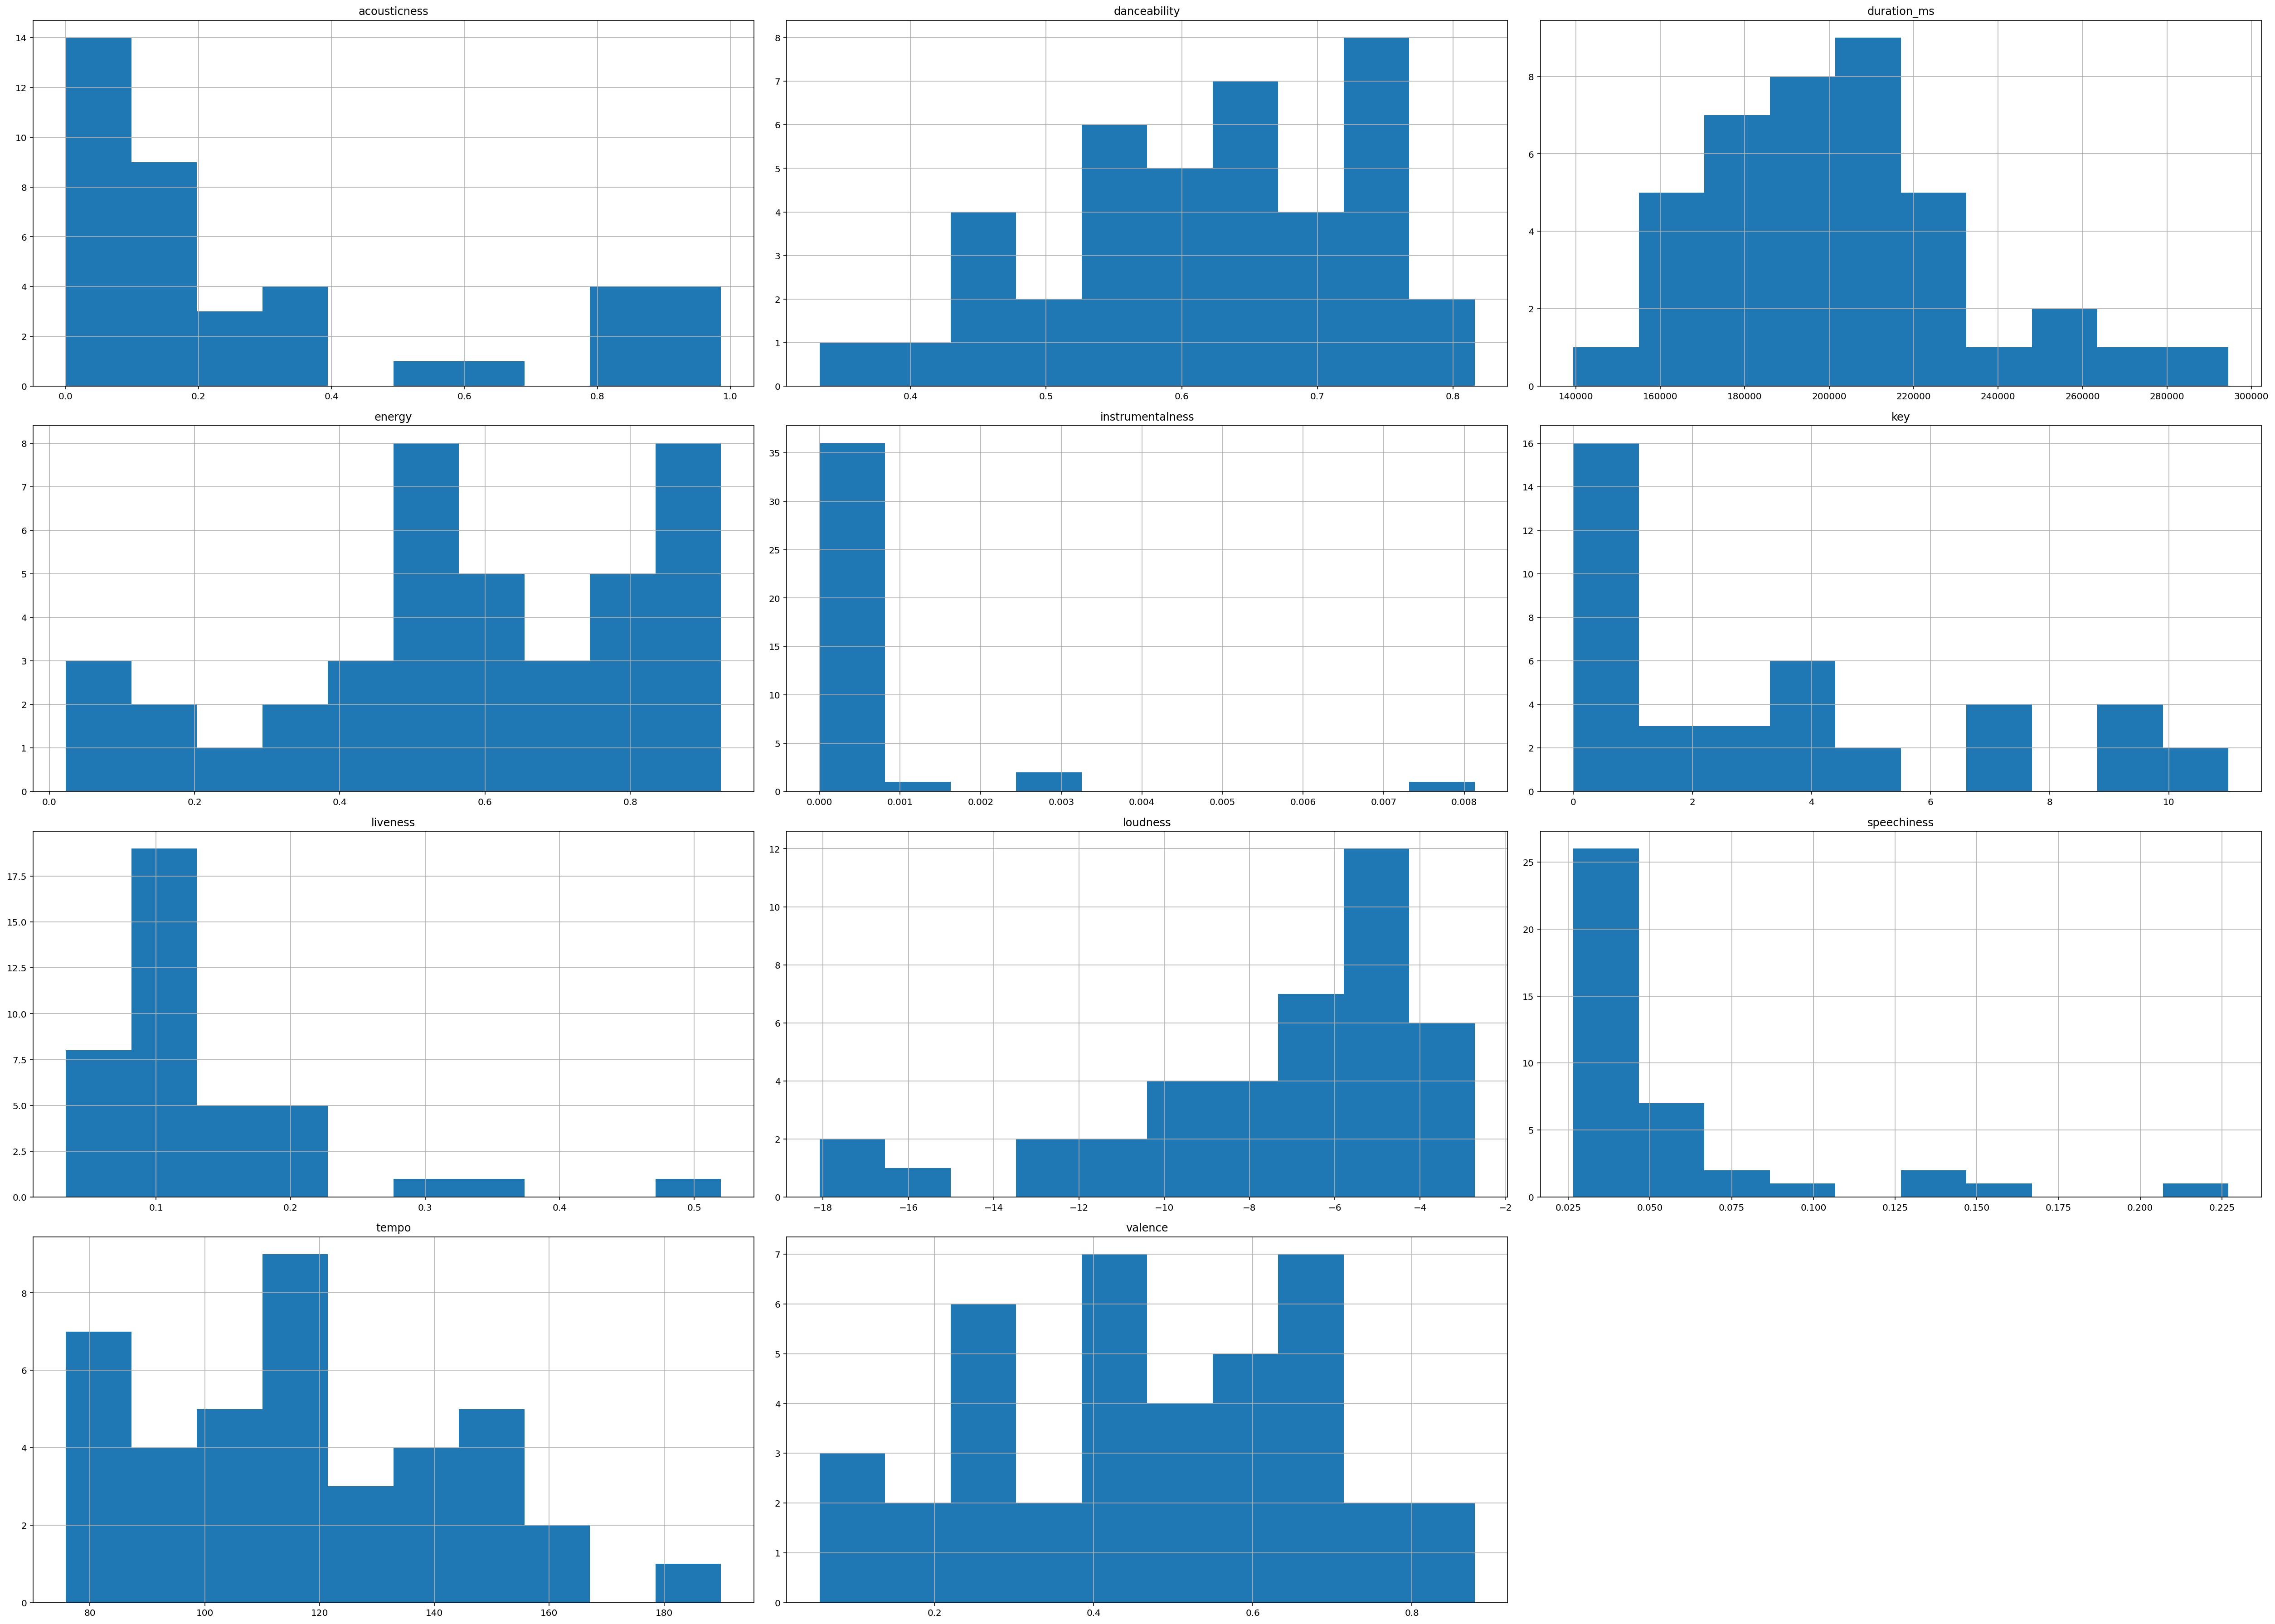

In [6]:
df_final_features.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()


## Playlist Extraction

### Featured Playlists Extraction

In [7]:
def featured_playlists(sp):
    id = []
    name = []
    num_tracks = []
    
    featured = sp.featured_playlists(sp)
    playlists = featured['playlists']
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_playlists = pd.DataFrame({'playlist_id':id, 'playlist_name':name, '#tracks': num_tracks})
    return df_playlists

In [8]:
df_featured_playlists = featured_playlists(sp)
df_featured_playlists

playlist_id                  playlist_name  #tracks
0   37i9dQZF1DXbcPC6Vvqudd                     Night Rain      220
1   37i9dQZF1DX8Sz1gsYZdwj                Classical Sleep       72
2   37i9dQZF1DX0QKpU3cGsyb                   Bedroom Jams       69
3   37i9dQZF1DWVvXA824aCbn                  The Piano Bar      127
4   37i9dQZF1DWZd79rJ6a7lp                          Sleep      257
5   37i9dQZF1DWX3387IZmjNa                         B.A.E.       50
6   37i9dQZF1DX4sWSpwq3LiO                 Peaceful Piano      308
7   37i9dQZF1DWYcDQ1hSjOpY                     Deep Sleep      258
8   37i9dQZF1DX2UgsUIg75Vg                    Chilled R&B       50
9   37i9dQZF1DXbZmKskFbVct            ASMR Sleep Whispers       56
10  37i9dQZF1DWWSads6V2oIk  The Sleep Machine: Rainforest       42
11  37i9dQZF1DWUZ5bk6qqDSy                    White Noise      110

### User Playlists Extraction

In [298]:
def user_playlist(sp,username):
    playlist_id = []
    playlist_name = []
    num_tracks = []
    
    featured = sp.user_playlists(username)
    for i, items in enumerate(featured['items']):
        playlist_id.append(items['id'])
        playlist_name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_your_lib = pd.DataFrame({'playlist_id':playlist_id, 'playlist_name':playlist_name, '#tracks': num_tracks})
    return df_your_lib
        

In [299]:
df_user_playlists = user_playlist(sp,username)
searchfor = ['Custom', 'Discover']
df_user_playlists =  df_user_playlists[~df_user_playlists['playlist_name'].str.contains('|'.join(searchfor))]
df_user_playlists

playlist_id                                      playlist_name  \
0   37i9dQZF1DX5Ejj0EkURtP                                        All Out 10s   
1   37i9dQZF1DXc6IFF23C9jj                                   Top Hits of 2010   
2   37i9dQZF1EMdcXI0FdmrA0                                Your Top Songs 2020   
3   1B9BPUMWDtl4ASyG4f693s                  Bruno Mars - Official Discography   
4   37i9dQZF1DWWF3yivn1m3D                                This Is Hans Zimmer   
5   5acGzAC0OH4QDVj5hlFqlK                                      Study with Me   
6   37i9dQZF1DX64Y3du11rR1                                         Sad Covers   
7   37i9dQZF1DXc3FQfFV3K6V                                  Laidback Acoustic   
8   0vvXsWCC9xrXsKd4FyS8kM       lofi hip hop music - beats to relax/study to   
9   37i9dQZF1DWWQRwui0ExPn                                        Lo-Fi Beats   
10  37i9dQZF1DWYfvJNWU1bKi                                      Tamil Romance   
11  37i9dQZF1DX8DxW4iib3Eq                                This Is John Legend   
12  37i9dQZF1DX177vQ7mVRmP                                 This Is Bruno Mars   
13  37i9dQZF1DX1riuLHc7Ui5                             This Is Camila Cabello   
14  37i9dQZF1DX29brXfjEm5q                                  This Is Sam Smith   
15  37i9dQZF1DWWxPM4nWdhyI                                 This Is Ed Sheeran   
16  2QAZ0bGlttwXms2ohJMVe9                                           Melodies   
17  7jZbNzzf4f0WsYR5v153UZ                         A.R. Rahman – 2.0 enthiran   
18  11oxVoG1vqvCP6fiqKwXEV                                  Tamil Dance Songs   
19  3C3GKlgR0uj0dm7jUA4zgW                                      NGHTMRE Radio   
20  2GrnA8IlKRBKNs8vgRHzGq                                   sad hindi songs    
21  37i9dQZF1DWYKzhEkKdUkK                                    Bollywood Blast   
22  1dMyrAIsCdMvqRupu27Bfi                            Lovely Songs <3 | Tamil   
23  6TIYmDn8GP5tbhtm0xDuRx                      Karthick Iyer Live – Indosoul   
24  6Hmuuko1DY7cULrpeFeSkd                                     Tamil Melodies   
25  37i9dQZF1DWXmlLSKkfdAk                                    Acoustic Covers   
26  74sUjcvpGfdOvCHvgzNEDO  lofi hip hop beats - music to study/relax to |...   
27  6A3Q5iGA2RvNqzdygcUvmd                     Violin Instrumental Love Songs   
28  37i9dQZF1DX9sIqqvKsjG8                                 Instrumental Study   
29  7tWeLQSWPitehz4jTCWtrB                                        Study music   
30  61pi0dy9neeNT1vwrWIoxL                                              Songs   
31  1SZ70MXbfW10nDAa07xMFk                                              Tamil   

    #tracks  
0       150  
1       100  
2       100  
3        38  
4        68  
5      1030  
6        61  
7       101  
8       309  
9       450  
10       98  
11       57  
12       43  
13       35  
14       49  
15       41  
16       47  
17        5  
18       92  
19      154  
20      240  
21       40  
22     1214  
23        6  
24      357  
25      163  
26      250  
27       49  
28      299  
29       78  
30       18  
31      601

## Fetch Tracks for each playlists

In [9]:
def get_playlist_tracks(sp, playlist_id):
    tracks = []
    offset = 0
    while True:
        track_list = sp.playlist_tracks(playlist_id, fields = None, limit = 100, offset = offset, market = None)
        tracks += track_list['items']
        
        if track_list['next'] is not None:
            offset +=100
        else:
            break
            
    track_id = []
    track_name = []
    
    try:
        for track in tracks:
            track_id.append(track['track']['id'])
            track_name.append(track['track']['name'])
    except:
            pass
    
    df_playlist_tracks = pd.DataFrame({'track_id':track_id, 'track_name': track_name})
    return df_playlist_tracks
    

## Get Audio Features for each track within a playlist

In [10]:
def get_audio_features(sp, playlist_id):
    playlist = get_playlist_tracks(sp, playlist_id)
    audio_features = []
    
    for i in range(len(playlist)):
        try:
            audio_features.append(sp.audio_features(playlist['track_id'][i]))
        except:
            pass
             
             
    feature_list = []
    for feature in audio_features:
        try:
            feature_list.append([feature[0]['danceability'],
                            feature[0]['energy'],
                            feature[0]['key'],
                            feature[0]['loudness'],
                            feature[0]['speechiness'],
                            feature[0]['acousticness'],
                            feature[0]['instrumentalness'],
                            feature[0]['liveness'],
                            feature[0]['valence'],
                            feature[0]['tempo'],
                            feature[0]['duration_ms']]
                               )
        except:
            pass

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    df_playlist_audio_features = df_playlist_audio_features.dropna()
    return df_playlist_audio_features
    

## Get the mean & merge each playlist

In [11]:
def get_audio_features_mean (sp, playlist_id):
    playlist = get_audio_features(sp, playlist_id)
    df_mean_playlist = pd.DataFrame(playlist.mean(),columns = [playlist_id])
    return df_mean_playlist

In [12]:
dataframes = []
for i in df_featured_playlists['playlist_id']:
    dataframes.append(get_audio_features_mean(sp, i))
    
dataframes
    

[                  37i9dQZF1DXbcPC6Vvqudd
 danceability                    0.143090
 energy                          0.744021
 key                             4.313636
 loudness                      -21.932473
 speechiness                     0.082850
 acousticness                    0.226699
 instrumentalness                0.867155
 liveness                        0.602012
 valence                         0.015402
 tempo                          90.886027
 duration_ms                184694.836364,
                   37i9dQZF1DX8Sz1gsYZdwj
 danceability                    0.300836
 energy                          0.039274
 key                             4.638889
 loudness                      -30.023417
 speechiness                     0.048289
 acousticness                    0.970972
 instrumentalness                0.869444
 liveness                        0.098786
 valence                         0.147419
 tempo                          99.772236
 duration_ms                21214

In [304]:
dataframes_user = []
for i in df_user_playlists['playlist_id']:
    dataframes_user.append(get_audio_features_mean(sp, i))
    
dataframes_user


[                  37i9dQZF1DX5Ejj0EkURtP
 danceability                    0.655820
 energy                          0.662243
 key                             5.366667
 loudness                       -5.620827
 speechiness                     0.086055
 acousticness                    0.181648
 instrumentalness                0.003914
 liveness                        0.147037
 valence                         0.490226
 tempo                         119.850493
 duration_ms                209190.806667,
                   37i9dQZF1DXc6IFF23C9jj
 danceability                    0.641090
 energy                          0.751320
 key                             5.260000
 loudness                       -4.987220
 speechiness                     0.095363
 acousticness                    0.116672
 instrumentalness                0.003646
 liveness                        0.195073
 valence                         0.565710
 tempo                         117.952870
 duration_ms                22678

In [13]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X = X[:10]
X = X.drop('instrumentalness', axis=0)
X

37i9dQZF1DXbcPC6Vvqudd  37i9dQZF1DX8Sz1gsYZdwj  \
danceability                0.143090                0.300836   
energy                      0.744021                0.039274   
key                         4.313636                4.638889   
loudness                  -21.932473              -30.023417   
speechiness                 0.082850                0.048289   
acousticness                0.226699                0.970972   
liveness                    0.602012                0.098786   
valence                     0.015402                0.147419   
tempo                      90.886027               99.772236   

              37i9dQZF1DX0QKpU3cGsyb  37i9dQZF1DWVvXA824aCbn  \
danceability                0.616493                0.465843   
energy                      0.512667                0.075593   
key                         5.144928                4.496063   
loudness                   -8.115449              -22.019039   
speechiness                 0.112984                0.047088   
acousticness                0.301822                0.961614   
liveness                    0.137933                0.116743   
valence                     0.414088                0.145561   
tempo                     117.355580               97.694063   

              37i9dQZF1DWZd79rJ6a7lp  37i9dQZF1DWX3387IZmjNa  \
danceability                0.185260                0.666080   
energy                      0.038644                0.573780   
key                         4.863813                4.760000   
loudness                  -30.057572               -7.357560   
speechiness                 0.041844                0.206202   
acousticness                0.951167                0.288301   
liveness                    0.106140                0.175342   
valence                     0.083682                0.450644   
tempo                      84.251650              108.656200   

              37i9dQZF1DX4sWSpwq3LiO  37i9dQZF1DWYcDQ1hSjOpY  \
danceability                0.381656                0.158340   
energy                      0.044988                0.075285   
key                         4.785714                4.713178   
loudness                  -26.812127              -27.725345   
speechiness                 0.047706                0.046178   
acousticness                0.991474                0.893014   
liveness                    0.105537                0.103958   
valence                     0.250269                0.060357   
tempo                     106.734721               92.757919   

              37i9dQZF1DX2UgsUIg75Vg  37i9dQZF1DXbZmKskFbVct  \
danceability                0.608220                0.517643   
energy                      0.506980                0.146053   
key                         5.220000                5.785714   
loudness                   -7.814260              -34.809857   
speechiness                 0.111824                0.211193   
acousticness                0.330442                0.107698   
liveness                    0.167074                0.222227   
valence                     0.398500                0.098596   
tempo                     118.533920               92.285625   

              37i9dQZF1DWWSads6V2oIk  37i9dQZF1DWUZ5bk6qqDSy  
danceability                0.185529                0.075192  
energy                      0.717426                0.225514  
key                         5.285714                4.747475  
loudness                  -25.071786              -26.061717  
speechiness                 0.111057                0.041390  
acousticness                0.422009                0.604397  
liveness                    0.538424                0.198492  
valence                     0.033623                0.017866  
tempo                      94.894143               57.318485

In [376]:
X_2 = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes_user)
X_2 = X_2[:10]
X_2

37i9dQZF1DX5Ejj0EkURtP  37i9dQZF1DXc6IFF23C9jj  \
danceability                    0.655820                0.641090   
energy                          0.662243                0.751320   
key                             5.366667                5.260000   
loudness                       -5.620827               -4.987220   
speechiness                     0.086055                0.095363   
acousticness                    0.181648                0.116672   
instrumentalness                0.003914                0.003646   
liveness                        0.147037                0.195073   
valence                         0.490226                0.565710   
tempo                         119.850493              117.952870   

                  37i9dQZF1EMdcXI0FdmrA0  1B9BPUMWDtl4ASyG4f693s  \
danceability                    0.664510                0.694000   
energy                          0.676670                0.684921   
key                             5.220000                3.815789   
loudness                       -6.566740               -5.497132   
speechiness                     0.077950                0.066234   
acousticness                    0.262011                0.176828   
instrumentalness                0.010617                0.000310   
liveness                        0.153269                0.162055   
valence                         0.545569                0.657184   
tempo                         119.529760              124.702158   

                  37i9dQZF1DWWF3yivn1m3D  5acGzAC0OH4QDVj5hlFqlK  \
danceability                    0.259207                0.251167   
energy                          0.265499                0.199991   
key                             4.764706                4.955078   
loudness                      -18.825971              -20.003024   
speechiness                     0.046128                0.043549   
acousticness                    0.530714                0.726229   
instrumentalness                0.784516                0.836103   
liveness                        0.136641                0.128580   
valence                         0.099951                0.101162   
tempo                         108.392926              102.738502   

                  37i9dQZF1DX64Y3du11rR1  37i9dQZF1DXc3FQfFV3K6V  \
danceability                    0.543180                0.561455   
energy                          0.196211                0.257869   
key                             4.868852                5.435644   
loudness                      -12.353672              -10.971139   
speechiness                     0.037708                0.044650   
acousticness                    0.852082                0.813079   
instrumentalness                0.004356                0.010340   
liveness                        0.125195                0.143969   
valence                         0.267602                0.359441   
tempo                         113.446525              116.026040   

                  0vvXsWCC9xrXsKd4FyS8kM  37i9dQZF1DWWQRwui0ExPn  ...  \
danceability                    0.633019                0.678338  ...   
energy                          0.236528                0.331056  ...   
key                             5.475728                5.355556  ...   
loudness                      -14.754540              -12.427378  ...   
speechiness                     0.088642                0.124382  ...   
acousticness                    0.722039                0.614101  ...   
instrumentalness                0.817682                0.762774  ...   
liveness                        0.149436                0.152775  ...   
valence                         0.248281                0.407510  ...   
tempo                         104.126172              104.910611  ...   

                  1dMyrAIsCdMvqRupu27Bfi  6TIYmDn8GP5tbhtm0xDuRx  \
danceability                    0.645260                0.542667   
energy                          0.576648                0.523000   
key           

In [14]:
y = pd.DataFrame(df_final_features.mean(), columns = ['top_playlist'])
y = y[:10]
y = y.drop('instrumentalness', axis=0)
y

top_playlist
danceability      0.616975
energy            0.578675
key               3.625000
loudness         -7.408175
speechiness       0.055445
acousticness      0.300379
liveness          0.135810
valence           0.476740
tempo           118.177050

## Memory Based Collaborative Filter

### Euclidean Distance - Featured

In [15]:
#Euclidian distance takes the magnitude of each element within the vector into consideration 
def euclidean_distance(user_playlist,featured_playlist):    
    x = np.sqrt(np.sum((user_playlist - featured_playlist) ** 2))
    return x

In [16]:
def euc_dataframe(user_playlist):
    featured = []
    distance_score = []
    for i in df_featured_playlists['playlist_id']:
        featured.append(i)
        distance_score.append(euclidean_distance(user_playlist,X[i]))
    df_euc_dist = pd.DataFrame({'featured_playlist':featured, 'distance_score':distance_score})
    sort_values = df_euc_dist.sort_values('distance_score', ascending = True)
    return sort_values

In [17]:
feat_dist = euc_dataframe(y['top_playlist'])
feat_top_3 = feat_dist.nsmallest(3,'distance_score')
feat_top_3

featured_playlist  distance_score
8  37i9dQZF1DX2UgsUIg75Vg        1.688989
2  37i9dQZF1DX0QKpU3cGsyb        1.869981
5  37i9dQZF1DWX3387IZmjNa        9.589834

### Euclidean Distance - User

In [390]:
def euc_dataframe(user_playlist):
    featured = []
    distance_score = []
    for i in df_user_playlists['playlist_id']:
        featured.append(i)
        distance_score.append(euclidean_distance(user_playlist,X_2[i]))
    df_euc_dist = pd.DataFrame({'featured_playlist':featured, 'distance_score':distance_score})
    sort_values = df_euc_dist.sort_values('distance_score', ascending = True)
    return sort_values

In [391]:
user_dist = euc_dataframe(y['top_playlist'])
user_dist = user_dist.drop(user_dist[user_dist['distance_score'] == 0.0000000].index)
user_top_3 = user_dist.nsmallest(3,'distance_score')
user_top_3

featured_playlist  distance_score
0   37i9dQZF1DX5Ejj0EkURtP        0.748584
2   37i9dQZF1EMdcXI0FdmrA0        1.251459
18  11oxVoG1vqvCP6fiqKwXEV        1.676768

## Create playlist df

### Create df for featured playlists

In [25]:
for i, playlist in enumerate(feat_top_3['featured_playlist']):
    try:
        string_command = "df_{} = get_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DX2UgsUIg75Vg = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX0QKpU3cGsyb = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWX3387IZmjNa = get_audio_features(sp, playlist)


In [82]:
def df_playlist(top_3):
    frames = []
    for i, playlist in enumerate(feat_top_3['featured_playlist']):
        string_command_2 = 'df_{}'.format(playlist)
#         string_command_2 = pd.Series(string_command_2)
        frames.append(string_command_2)
    return frames
    

In [84]:
top_playlists = df_playlist(feat_top_3['featured_playlist'])
top_playlists

['df_37i9dQZF1DX2UgsUIg75Vg',
 'df_37i9dQZF1DX0QKpU3cGsyb',
 'df_37i9dQZF1DWX3387IZmjNa']

### Create df for user playlists

In [314]:
for i, playlist in enumerate(user_top_3['featured_playlist']):
    try:
        string_command = "df_{} = get_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DX5Ejj0EkURtP = get_audio_features(sp, playlist)
Create df_37i9dQZF1DXc6IFF23C9jj = get_audio_features(sp, playlist)
Create df_37i9dQZF1EMdcXI0FdmrA0 = get_audio_features(sp, playlist)
Create df_1B9BPUMWDtl4ASyG4f693s = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWWF3yivn1m3D = get_audio_features(sp, playlist)
Create df_5acGzAC0OH4QDVj5hlFqlK = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX64Y3du11rR1 = get_audio_features(sp, playlist)
Create df_37i9dQZF1DXc3FQfFV3K6V = get_audio_features(sp, playlist)
Create df_0vvXsWCC9xrXsKd4FyS8kM = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWWQRwui0ExPn = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWYfvJNWU1bKi = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX8DxW4iib3Eq = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX177vQ7mVRmP = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX1riuLHc7Ui5 = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX29brXfjEm5q = get_audio_fea

## Create Dataframe with top 3 playlists

### Featured Dataframe

In [85]:
frames_featured = [df_37i9dQZF1DX2UgsUIg75Vg,df_37i9dQZF1DX0QKpU3cGsyb,df_37i9dQZF1DWX3387IZmjNa]
df =pd.concat(frames_featured)
df = df.set_index(['track_id'])
del df['track_name']
del df['duration_ms']
del df['instrumentalness']
df

danceability  energy  key  loudness  speechiness  \
track_id                                                                   
5DNa1gmm4SVyAjAFGmUrTd         0.402   0.369    4    -9.166       0.0851   
6UF1vUIoLleFrhcxg2L26V         0.566   0.693   10    -6.917       0.3680   
2uddLj27GIDBIdwRuIomE4         0.746   0.454    9    -8.790       0.0583   
72rJE1F8Gy2V07SaWG9ZWV         0.525   0.240    5    -7.568       0.0267   
08HPWLi0YmRUStJzkQ1ffh         0.599   0.449    7    -7.423       0.0529   
...                              ...     ...  ...       ...          ...   
6hhHBi9xrYwjtQK1T4mYD0         0.762   0.737    5    -5.290       0.2970   
5KhWSvBNRGxY5I3t0X6f4w         0.644   0.436    2    -6.104       0.2970   
0WQwSgQD1pajaWeqPWt1KT         0.617   0.724   11    -6.605       0.3300   
4gKCKkQbtejYebL9Km5cu1         0.636   0.418    4   -10.536       0.0316   
6Iw6fQVKZi0fWtEQBrTFcP         0.467   0.429    6    -8.689       0.0964   

                        acousticness  liveness  valence    tempo  
track_id                                                          
5DNa1gmm4SVyAjAFGmUrTd        0.1340    0.1110    0.212  174.376  
6UF1vUIoLleFrhcxg2L26V        0.3610    0.0806    0.838   78.743  
2uddLj27GIDBIdwRuIomE4        0.1220    0.2960    0.268  121.921  
72rJE1F8Gy2V07SaWG9ZWV        0.9390    0.1050    0.369   90.147  
08HPWLi0YmRUStJzkQ1ffh        0.1610    0.1070    0.143  158.000  
...                              ...       ...      ...      ...  
6hhHBi9xrYwjtQK1T4mYD0        0.1150    0.1700    0.641   97.942  
5KhWSvBNRGxY5I3t0X6f4w        0.4150    0.1560    0.342   82.484  
0WQwSgQD1pajaWeqPWt1KT        0.0813    0.1070    0.537   79.946  
4gKCKkQbtejYebL9Km5cu1        0.5030    0.1130    0.347   96.132  
6Iw6fQVKZi0fWtEQBrTFcP        0.8150    0.1770    0.240  148.530  

[169 rows x 9 columns]

### Calculate Std.Deviation of the top tracks to tracks in top 3 playlists

In [108]:
df1 = df.subtract(y['top_playlist'], axis ='columns')
df1 = df1 ** 2
df1['std_dev'] = df1.sum(axis=1)
df1['std_dev'].divide(len(df1))
np.sqrt(df1['std_dev'])
df1= df1.drop_duplicates(subset ="std_dev", keep = False)
df1

danceability    energy        key   loudness  \
track_id                                                               
5DNa1gmm4SVyAjAFGmUrTd  4.621425e-02  0.043964   0.140625   3.089949   
6UF1vUIoLleFrhcxg2L26V  2.598451e-03  0.013070  40.640625   0.241253   
72rJE1F8Gy2V07SaWG9ZWV  8.459401e-03  0.114701   1.890625   0.025544   
7JeCUUnOpoz4JoV84fliOc  2.130870e-02  0.002989   5.640625   2.748384   
5A3aEJL7HkijkxLFXMv7FN  2.598451e-03  0.049140  40.640625  12.417343   
...                              ...       ...        ...        ...   
6hhHBi9xrYwjtQK1T4mYD0  2.103225e-02  0.025067   1.890625   4.486665   
5KhWSvBNRGxY5I3t0X6f4w  7.303506e-04  0.020356   2.640625   1.700872   
0WQwSgQD1pajaWeqPWt1KT  6.250000e-10  0.021119  54.390625   0.645090   
4gKCKkQbtejYebL9Km5cu1  3.619506e-04  0.025816   0.140625   9.783289   
6Iw6fQVKZi0fWtEQBrTFcP  2.249250e-02  0.022403   5.640625   1.640513   

                        speechiness  acousticness  liveness   valence  \
track_id                                                                
5DNa1gmm4SVyAjAFGmUrTd     0.000879      0.027682  0.000616  0.070087   
6UF1vUIoLleFrhcxg2L26V     0.097691      0.003675  0.003048  0.130509   
72rJE1F8Gy2V07SaWG9ZWV     0.000826      0.407837  0.000949  0.011608   
7JeCUUnOpoz4JoV84fliOc     0.000536      0.001882  0.247198  0.002888   
5A3aEJL7HkijkxLFXMv7FN     0.027741      0.081042  0.000219  0.066430   
...                             ...           ...       ...       ...   
6hhHBi9xrYwjtQK1T4mYD0     0.058349      0.034365  0.001169  0.026981   
5KhWSvBNRGxY5I3t0X6f4w     0.058349      0.013138  0.000408  0.018155   
0WQwSgQD1pajaWeqPWt1KT     0.075380      0.047996  0.000830  0.003631   
4gKCKkQbtejYebL9Km5cu1     0.000569      0.041055  0.000520  0.016832   
6Iw6fQVKZi0fWtEQBrTFcP     0.001677      0.264835  0.001697  0.056046   

                              tempo      std_dev  
track_id                                          
5DNa1gmm4SVyAjAFGmUrTd  3158.321981  3161.741997  
6UF1vUIoLleFrhcxg2L26V  1555.044299  1596.176768  
72rJE1F8Gy2V07SaWG9ZWV   785.683703   788.144253  
7JeCUUnOpoz4JoV84fliOc  1160.018887  1168.684697  
5A3aEJL7HkijkxLFXMv7FN  1352.257206  1405.542344  
...                             ...          ...  
6hhHBi9xrYwjtQK1T4mYD0   409.457249   416.001502  
5KhWSvBNRGxY5I3t0X6f4w  1273.993818  1278.446452  
0WQwSgQD1pajaWeqPWt1KT  1461.613184  1516.797856  
4gKCKkQbtejYebL9Km5cu1   485.984230   495.993299  
6Iw6fQVKZi0fWtEQBrTFcP   921.301574   928.951861  

[143 rows x 10 columns]

In [109]:
df2 = df1.sort_values('std_dev', ascending = True).head(50)
df2

danceability        energy        key   loudness  \
track_id                                                                   
5ySgoLDkm2yzeFlpay5YBB  2.027251e-03  3.442756e-03   5.640625   0.615950   
7Bar1kLTmsRmH6FCKKMEyU  3.847101e-03  3.928156e-03  13.140625   1.075732   
3a8vuQ21AzGHP82BmrMV0H  9.506250e-07  3.220563e-05  19.140625   1.199408   
2qEndGWSu39bLjOBoU2xLq  2.756430e-02  3.447521e-02   1.890625   6.811187   
3WnTQDd9A3bpBfzCziElU9  2.044185e-02  1.047041e-02   0.140625  15.485602   
5ImksaSTPcJFGCyUM26T7Q  2.280855e-02  2.532606e-03  13.140625   3.126443   
02nZeTbm2dRHisH6qsUM5E  1.464705e-02  3.987011e-02   2.640625  17.942213   
02mgNHQPcvcIQA9RcpJTpF  8.395506e-04  2.240261e-02   0.140625   3.221397   
3RniWkfPXJGxxM4IeBBRCe  6.918215e-02  2.035616e-02   5.640625   7.085312   
423NhOTzoqgeaIJbrUzSoo  1.761901e-03  1.840771e-02  11.390625  17.790048   
0dGe86ljF6Xi19IxYc7aBn  5.154035e-02  2.392436e-02   2.640625   0.915514   
1EWa3LGA6yaC6Bq2iUA72a  4.121915e-02  2.613881e-02   1.890625   7.844621   
1k7dy3fdY0ABWQFhE3TDyL  3.570062e-05  3.471701e-02   6.890625   0.024704   
7MzfIynupRkSPo1CMVBGem  5.291150e-02  5.137306e-03  19.140625   1.243615   
7a3TW5w1K6kJpm35kqps5V  1.124130e-02  9.965071e-02  28.890625   7.451945   
2Qti0PJLbCtqN8TGZ7hUu5  7.391701e-03  1.400081e-02   6.890625   0.083622   
1RDLbX9L2G4zDqxXCaMJo5  1.613535e-02  6.435101e-02   0.390625   4.388292   
18jvxnVVhtTVhLL6dE1JPs  4.162620e-02  4.354526e-02  19.140625  11.949639   
2ENxOXbxhfJ3lfItO0MFDv  4.359301e-03  8.588656e-03   0.140625   5.372313   
2oWF2Cz8LFNc4ArykxY4uT  6.893151e-03  6.777406e-03  19.140625   0.982428   
2J1t1HhcO5sxYBrCKnEdF9  7.671515e-02  2.330966e-02  54.390625   0.036931   
1rxXjDzwNSP36csjm7Zmzf  8.653651e-03  2.737906e-03   6.890625   0.023770   
6pduF6NCbC5Cymo3AFqNr3  2.623590e-02  1.269566e-02   5.640625   0.004925   
0Erf8mE7jAm6j94z48dxPx  5.044551e-03  5.087256e-03   5.640625   5.518623   
4FQg9eezgtA5DVaYcyCyFi  5.242955e-02  1.870562e-05  11.390625   1.394348   
4Xr6BbSSu5HhImp8vfxMbg  3.801525e-02  4.067281e-02   6.890625   0.501512   
034KyQEk7IhbLtniVhBErj  3.478051e-03  4.608536e-02   1.890625   1.574586   
7sdRFe7nMpCLSIwVTSgPRg  3.840901e-03  1.870562e-05   2.640625   5.190081   
15hiUMS0HDjcyWzVlBEh1y  1.368315e-02  2.778056e-02   1.890625   1.322098   
5ELIl3vnSY0mF7jpf7lyhC  1.166940e-02  2.093086e-02  19.140625   1.061261   
2NxBM0HQWro208pY5vOJLn  7.748401e-03  6.943056e-03  54.390625   4.644779   
2Bm2pjLh2wlYwZ4nrcY6wU  2.118301e-03  1.846206e-01   0.140625  46.660170   
21CvSW5NIu5Glg9x3BPxjj  7.508970e-02  5.230906e-03  13.140625  19.379145   
7AqxZ0ePVqhQRWPKsSjylG  3.687360e-02  1.159391e-02   5.640625   6.131443   
71hBQ9qHsZU2M3vDF8MtaN  1.960700e-02  1.821156e-03   6.890625   0.348307   
5lC9Ag0RGXt72JwAinwTcF  4.797195e-02  1.978946e-02  54.390625   3.033954   
2KkNkv6ciB6bt2hvHtOrin  1.154301e-03  3.509066e-02  54.390625   7.103158   
23DKGdFZaYR32epRm5RQSJ  1.690650e-02  4.339931e-02   1.890625   1.560438   
274cgwC7QrE05PNXl9eo8z  8.104501e-03  5.032171e-02   2.640625  12.167365   
4RKJRRd4VJfZWiqQTYsleE  6.554880e-02  1.350563e-05  40.640625   0.015419   
3yFwdxTgEIeFVDiYaJtbhN  4.627401e-03  2.567956e-03   0.390625   2.628208   
68ndzgs983ZubXDHPclWG6  3.847101e-03  1.217161e-02  11.390625   3.687072   
0EgXGVCz5rBHg548WlsyiY  6.884851e-03  2.581646e-02  28.890625   7.058719   
5yJ5En03kTuWheu9AJqmhV  3.972151e-03  3.597661e-02   0.140625   5.052717   
1VAKnb1btGrQXcVZVSRkPe  1.683051e-03  1.626106e-03  28.890625   0.008496   
28LCprlRExHOgeFJu288q6  4.841100e-02  3.673931e-02  54.390625   8.754645   
5kAm2Y5ygQtsVfE5dQQfGy  3.879915e-02  4.556250e-07  19.140625   2.136932   
0taI7MiQGvdz3ZK1FgFRk5  3.483951e-03  5.726706e-03   6.890625   3.964778   
59Vf2uyRLPrVqXkCKRhyjE  5.187601e-03  2.178556e-03  11.390625   0.418383   
6MOovkZjVPHVFIjBHDQFyb  1.123070e-02  5.003051e-02  11.390625  16.997686   

                         speechiness  acousticness  liveness   valence 

### User Dataframe

In [99]:
frames_user = [df_37i9dQZF1DX5Ejj0EkURtP, df_37i9dQZF1EMdcXI0FdmrA0, df_11oxVoG1vqvCP6fiqKwXEV]
frames_user
df_user =pd.concat(frames_user)
df_user = df_user.set_index(['track_id'])
del df_user['track_name']
del df_user['duration_ms']
df_user

NameError: name 'df_37i9dQZF1DX5Ejj0EkURtP' is not defined

### Calculate Std.Deviation of the top tracks to tracks in top 3 playlists

In [54]:
df_user1 = df_user.subtract(y['top_playlist'], axis ='columns')
df_user1 = df_user1 ** 2
df_user1['std_dev'] = df_user1.sum(axis=1)
df_user1['std_dev'].divide(len(df_user1))
np.sqrt(df_user1['std_dev'])
df_user1

NameError: name 'df_user' is not defined

In [402]:
df_user2 = df_user1.sort_values('variance', ascending = True).head(50)
df_user2

danceability    energy    key   loudness  speechiness  \
track_id                                                                        
5v7gCLVyLgpO5L6zdeXULd  3.878536e-02  0.006072   0.04   1.560800     0.000288   
5GUM2uDH9Ey4aSvKz1lIdG  4.217204e-03  0.035314   0.04   1.843295     0.006215   
0MU3DZ68Y09aNseo2e8JJJ  2.990824e-02  0.014622   1.44   1.668437     0.000890   
2FbaDGEi0rA1AB3bieJKuk  4.925736e-02  0.000098   3.24   0.214999     0.001820   
3rVBZoeJT4lIr1S9EeENtc  5.467124e-03  0.018747   1.44   0.060359     0.004104   
2iUXsYOEPhVqEBwsqP70rE  5.634004e-03  0.009984   3.24   0.495166     0.127331   
39IsH7B5byx8NRlEKlZVg9  1.020164e-03  0.012978   3.24   1.337909     0.005939   
4nVBt6MZDDP6tRVdQTgxJg  5.049524e-03  0.008296   4.84   0.000246     0.003418   
4lYKuF88iTBrppJoq03ujE  7.045924e-03  0.001438   1.44   4.497284     0.000599   
0WdbnNKO0Jt4BZACSDQh44  5.731236e-04  0.000733   0.64   0.208228     0.005456   
2gqapLp6Br7jcR1QQNBVFz  4.243600e-06  0.021928   0.64  12.015374     0.004003   
3DmW6y7wTEYHJZlLo1r6XJ  7.806436e-04  0.050661  10.24   2.994007     0.003302   
6XT0HcEyNMV2w8KgzlWiyp  4.769284e-03  0.008479   0.04   8.639602     0.002584   
79cuOz3SPQTuFrp8WgftAu  3.457368e-02  0.002109  10.24   3.177948     0.002291   
0j2WBxWZnWti5TpSxjJvPb  3.357044e-03  0.043297   3.24  12.161401     0.006032   
3y3brCCecHC3Db18aIOnny  6.409604e-03  0.002409  14.44   0.491850     0.000738   
2qT1uLXPVPzGgFOx4jtEuo  7.806436e-04  0.001688  14.44   0.096522     0.002187   
0DKT3yIip1M0W0J1HYS1ru  4.891604e-03  0.001527  17.64   0.102836     0.005908   
519uJbE3zyKLlToVA65PrP  3.672360e-05  0.002925  17.64   0.759826     0.004117   
3qY7DJwj6Q4rqsTljv8Cjx  2.622456e-02  0.030948  14.44   6.203487     0.003117   
0NwXTIOMMJUEdnlvDhr7e2  1.843844e-03  0.007935   1.44   0.011811     0.005832   
6g1NlCpW7fgqDnWbCCDrHl  1.933768e-02  0.000836  10.24   0.014564     0.002902   
4YIhJmihoXwjtbY4vsV9Nh  2.654944e-02  0.004367  14.44   2.810049     0.001670   
4ofwffwvvnbSkrMSCKQDaC  8.836000e-07  0.000364   0.04   1.176531     0.003656   
3SvKIZDV1zurOUphVI7uWR  2.159136e-02  0.000788   3.24   1.068494     0.024912   
1CUVN2kn7mW5FjkqXTR2W1  5.032484e-03  0.004215  17.64   0.260794     0.003302   
6LsAAHotRLMOHfCsSfYCsz  4.384836e-04  0.003016  10.24   2.623363     0.002113   
6LsAAHotRLMOHfCsSfYCsz  4.384836e-04  0.003016  10.24   2.623363     0.002113   
6v3KW9xbzN5yKLt9YKDYA2  7.733444e-03  0.042469  14.44   0.053509     0.005955   
0TK2YIli7K1leLovkQiNik  7.733444e-03  0.045830  14.44   0.048983     0.006001   
0TK2YIli7K1leLovkQiNik  7.733444e-03  0.045830  14.44   0.048983     0.006001   
0JX7Es2j556FwtR6YqMKzP  1.714528e-02  0.000080  27.04   0.407452     0.005266   
3Ss0h6wRTuYwnIPXOYa9bs  8.475044e-03  0.006548  14.44   1.909040     0.007540   
7xoUc6faLbCqZO6fQEYprd  1.854164e-03  0.025947   7.84   0.611024     0.005456   
7nAJz8lfy2wtkPOBROSATs  1.743984e-02  0.008449   0.64   0.370491     0.003927   
22kRCQPyNXWZSQEcDvCmGD  3.763600e-06  0.008296   1.44  17.709957     0.003790   
049rbQFWg5J85XAhtWTzL8  2.869636e-04  0.002696   1.44  10.174059     0.000198   
5fX2oPyLCe5mBKqGDbOWqC  7.992360e-05  0.094913   3.24   0.048983     0.006094   
7ef4DlsgrMEH11cDZd32M6  1.438560e-02  0.011647  14.44   6.644434     0.000015   
1pwo8l3Ko7idwaz4LVUEC4  1.039176e-02  0.000050   0.04   3.085925     0.000298   
72gv4zhNvRVdQA0eOenCal  1.930724e-03  0.022225  27.04   0.475659     0.004015   
1x5sYLZiu9r5E43kMlt9f8  1.291684e-03  0.015645  27.04   1.529377     0.002487   
09sq0BHe85uV2ADUx1gaiA  1.229204e-03  0.000956   3.24   1.120041     0.006126   
2ekn2ttSfGqwhhate0LSR0  8.270084e-03  0.002925  14.44   0.041339     0.001352   
0b4C8AiF7eVbZCNGFrx1rv  4.037688e-02  0.000009  27.04   1.025521     0.000782   
28veUNu4veN0LOBVa0nFw8  1.767304e-02  0.025256  27.04   7.196772     0.000166   
5KawlOMHjWeUjQtnuRs22c  6.791236e-04  0.011647  33.64   1.125042     0.000093   
1DFD5Fotzgn6yYXkYsKiGs  3.528360e-05  0.000102  23.04  

## Create Discover Playlist

In [110]:
def create_playlist (sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)
    return playlists

In [111]:
today = str(date.today())
playlist_name = 'Discover Playlist ' + today
disc_pl = create_playlist(sp,username, playlist_name, 'Data Based Discover Playlist Created')
disc_code = disc_pl['uri']
disc_link = disc_code.partition("playlist:")[2]

In [112]:
def custom_playlist(sp, username, playlist_id, playlist_tracks):
    results = []
    results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[0:50])
    

In [113]:
disc_tracklist = df2.index
custom_playlist (sp, username, disc_link , disc_tracklist)

## Create Custom Playlist

In [403]:
today = str(date.today())
playlist_name2 = 'Custom Playlist ' + today
custom_pl = create_playlist(sp,username, playlist_name2, 'Data Based Custom Playlist Created')
custom_code = custom_pl['uri']
custom_link = custom_code.partition("playlist:")[2]

In [404]:
def custom_playlist(sp, username, playlist_id, playlist_tracks):
    results = []
    results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[0:50])

In [405]:
cust_tracklist = df_user2.index
custom_playlist (sp, username, custom_link , cust_tracklist)